# Conceptual Test

In [1]:
import torch
import torch.nn as nn
# import torch.optim
import numpy as np
import matplotlib.pyplot as plt
torch.__version__

'1.0.1.post2'

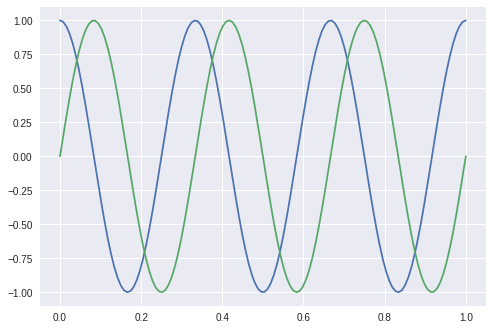

In [2]:
f = 3
t = np.linspace(0, 1, 128)
sig = np.exp(1j*2*np.pi*f*t)
# sig.dtype
plt.plot(t, sig.real)
plt.plot(t, sig.imag)
plt.show()
# sig = np.vstack([sig.real, sig.imag])
# sig.shape

In [0]:
def rrcosdesign(beta, span, sps):
    """
    returns the coefficients, that correspond to a square-root raised 
    cosine FIR filter with rolloff factor specified by beta. The filter 
    is truncated to span symbols, and each symbol period contains sps 
    samples. The order of the filter, sps*span, must be even. 
    modified from:
    https://github.com/veeresht/CommPy/blob/master/commpy/filters.py
    """
    n = sps*span
    rrc = np.zeros(n, dtype=float)
        
    for x in np.arange(n):
        t = (x-n/2)/sps
        if t == 0.0:
            rrc[x] = 1.0 - beta + (4*beta/np.pi)
        elif beta != 0 and t == 1/(4*beta):
            rrc[x] = ((beta/np.sqrt(2))*(((1+2/np.pi)*(np.sin(np.pi/
                     (4*beta)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*beta))))))
        elif beta != 0 and t == -1/(4*beta):
            rrc[x] = ((beta/np.sqrt(2))*(((1+2/np.pi)*(np.sin(np.pi/
                     (4*beta)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*beta))))))
        else:
            rrc[x] = ((np.sin(np.pi*t*(1-beta))+4*beta*(t)*np.cos(np.pi*
                     t*(1+beta)))/(np.pi*t*(1-(4*beta*t)*(4*beta*t))))
        
    return rrc

def gaussdesign(bt,span,sps):
    """
    Gaussian FIR Pulse-Shaping Filter Design
    converted from Matlab
    
    pulse-shaping filter. BT is the 3-dB bandwidth-symbol time product,
    where B is the one-sided bandwidth in hertz and T is the symbol time in
    seconds. The filter is truncated to SPAN symbols and each symbol is
    represented by SPS samples.
    the filter order which is SPS*SPAN, must be even
    """

    filtLen = sps*span+1
    t = np.linspace(-span/2,span/2,filtLen)
    alpha = np.sqrt(np.log(2)/2)/(bt)
    h = (np.sqrt(np.pi)/alpha)*np.exp(-(t*np.pi/alpha)**2)
    h = h/np.sum(h)
    return h

def upsample(x, n):
    """
    increase sample rate by integer factor
    y = upsample(x,n) increases the sample rate of x by 
    inserting n – 1 zeros between samples.
    input is 1D numpy array
    
    """
    zo = np.zeros((len(x), n), dtype=x.dtype)
    zo[:,0] += x
    return zo.flatten()

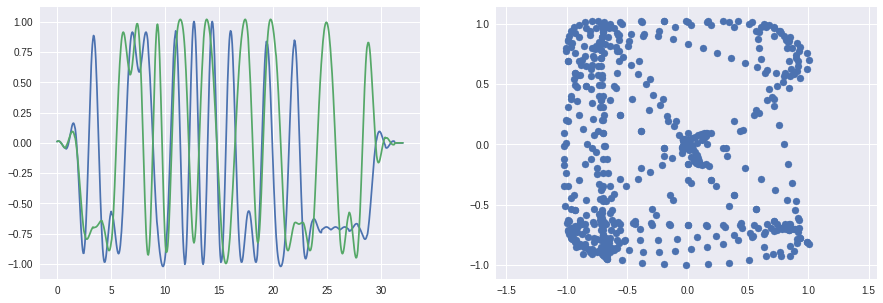

In [15]:
# QPSK generator
M = 4 # QPSK
SYMB = 32 # num of symbols
beta, span, sps = 0.4, 6, 16

rrc = rrcosdesign(beta, span, sps)
msg = np.random.randint(0, M, SYMB) # 0~3
sig_mod = np.exp(1j*(np.pi/M+msg*(2*np.pi/M))) # k/4*pi k=0~3
# pluse shaping 
sig_up = upsample(sig_mod, sps) # SYMB*sps (512,)
sig_pulse = np.convolve(sig_up, rrc) # (607,)

t = np.linspace(0, SYMB, sig_pulse.size)

fig,ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(t, sig_pulse.real)
ax[0].plot(t, sig_pulse.imag)
# plt.show()
ax[1].scatter(sig_pulse.real, sig_pulse.imag)
ax[1].axis('equal')
plt.show()

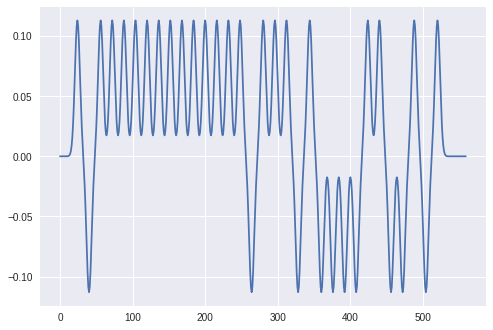

In [24]:
# GFSK generator
bt = 0.6  # bandwidth time product
mi = 0.5  # modulation index, phase change in one bit
span  = 3
msg = np.random.randint(0, 2, SYMB) # 0~1
sig_mod = msg*2-1
sig_up = upsample(sig_mod, sps)
gaus = gaussdesign(bt,span,sps)
sig_pulse = np.convolve(sig_up, gaus)
plt.plot(sig_pulse)
plt.show()


# phase = 2*np.pi*mi
# sig = np.exp(1j*phase)

In [0]:
class CVcnn(torch.nn.Module):
    def __init__(self):
        super(CVcnn, self).__init__()
        
        self.conv1_r = nn.Conv1d(1, 8, 5)
        self.conv1_i = nn.Conv1d(1, 8, 5)
        
        self.conv2_r = nn.Conv1d(8, 8, 5)
        self.conv2_i = nn.Conv1d(8, 8, 5)
        
    def forward(self, x_r, x_i):
        (y_r, y_i) = (self.conv1_r(x_r) - self.conv1_i(x_i),
                      self.conv1_r(x_i) + self.conv1_i(x_r))
        
        (y_r, y_i) = (self.conv2_r(y_r) - self.conv2_i(y_i),
                      self.conv2_r(y_i) + self.conv2_i(y_r))
        
        return y_r, y_i
    
    
net = CVcnn()
print('Number of parameters: {}'.format(sum(p.numel() for p in net.parameters())))

x_r = torch.from_numpy(sig.real).float().view(1, 1, -1)
x_i = torch.from_numpy(sig.imag).float().view(1, 1, -1)
y_r, y_i = net(x_r, x_i)

print(x_r.shape, y_r.shape)

Number of parameters: 752
torch.Size([1, 1, 128]) torch.Size([1, 8, 120])


In [0]:
class RVcnn(torch.nn.Module):
    def __init__(self):
        super(RVcnn, self).__init__()
        
        self.conv1 = nn.Conv1d(2, 8, 5)
        self.conv2 = nn.Conv1d(8, 8, 5)
#         self.conv1_i = nn.Conv1d(1, 2, 5) 
    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
#         y_r = self.conv1_r(x_r) - self.conv1_i(x_i)
#         y_i = self.conv1_r(x_i) + self.conv1_i(x_r)
        return y

net = RVcnn()
print('Number of parameters: {}'.format(sum(p.numel() for p in net.parameters())))

x_r = torch.from_numpy(sig.real).float().view(1, 1, -1)
x_i = torch.from_numpy(sig.imag).float().view(1, 1, -1)
x = torch.cat((x_r, x_i), 1)
y= net(x)

print(x.shape, y.shape)

Number of parameters: 416
torch.Size([1, 2, 128]) torch.Size([1, 8, 120])
